In [1]:
# Load all helper function
%run -i '../util/helper.py'

# Load Dataset and Data Split

In [2]:
df = pd.read_csv('../Dataset/brazilian_ecommerce_encoded.csv')
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
y = df["is_delayed"]
X = df.drop(["is_delayed", "Unnamed02"], axis=1, inplace=False)

In [3]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, random_state=random_state, test_size=0.2, stratify=y)

In [4]:
print(X_dev.shape)
print(X_test.shape)

(92506, 29)
(23127, 29)


# Hyperparameter Tuning

## Stratified Sampling

### GridSearch

In [5]:
parameter_grid = {'num_leaves': [31, 63, 127],
                  'max_depth': [-1, 10, 20, 40],
                  'n_estimators': [100,200,300]}
pipe_LGB = make_pipeline(GridSearchCV(lgb.LGBMClassifier(random_state=random_state),
                                      param_grid=parameter_grid,
                                      return_train_score=True,
                                      cv=StratifiedKFold(n_splits=10,shuffle=False),
                                      n_jobs=-1, 
                                      scoring=['recall','f1'],
                                      refit='f1'))
start3 = time()
pipe_LGB.fit(X_dev, np.ravel(y_dev))
end3 = time()
print("LightGBM model takes " + str(end3-start3) + "seconds")
print("The performance of the LightGBM model on test data is ", pipe_LGB.score(X_test, y_test))
grid_search_LGB = pipe_LGB.named_steps["gridsearchcv"]
print(f"The LightGBM model Best hyperparameters is ", grid_search_LGB.best_params_)

LightGBM model takes 1612.0876061916351seconds
The performance of the LightGBM model on test data is  0.5548577761359438
The LightGBM model Best hyperparameters is  {'max_depth': 20, 'n_estimators': 300, 'num_leaves': 127}


### Evaluate on the Test Set

In [6]:
LGB_prediction = pipe_LGB.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test,LGB_prediction)}')
print(f'Recall: {recall_score(y_test,LGB_prediction)}')
print(f'Precision: {precision_score(y_test,LGB_prediction)}')
print(f'F-1 Score: {f1_score(y_test,LGB_prediction)}')

recall, precision = recall_score(y_test,LGB_prediction), precision_score(y_test,LGB_prediction)

Accuracy: 0.9478963981493492
Recall: 0.4308663224325875
Precision: 0.779045643153527
F-1 Score: 0.5548577761359438


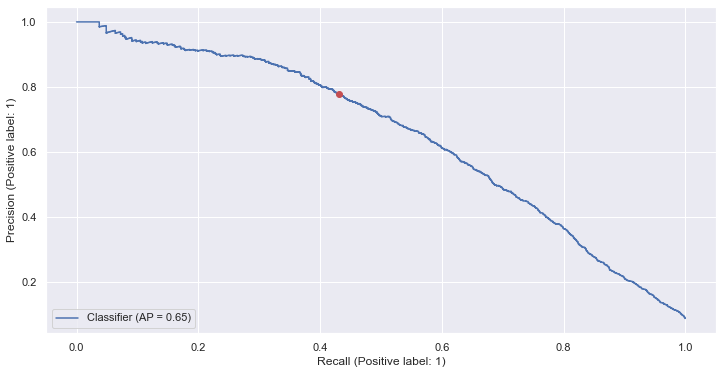

In [7]:
probs = pipe_LGB.predict_proba(X_test)[:,1]
PrecisionRecallDisplay.from_predictions(y_test, probs)
plt.plot(recall,precision,'ro');

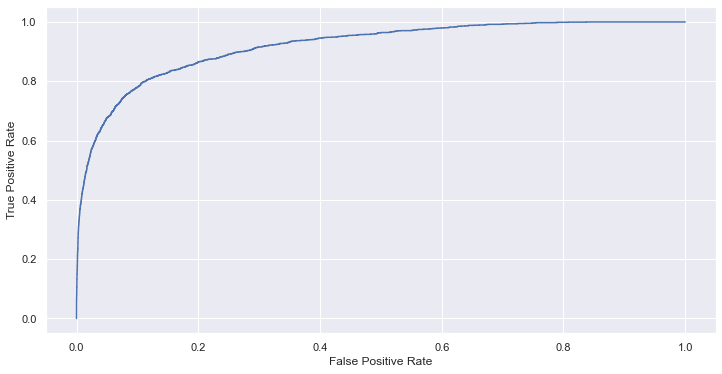

In [8]:
fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label = 1)
disp = RocCurveDisplay(fpr = fpr, tpr = tpr)
disp.plot()

Text(0.5, 1.0, 'Feature Importance')

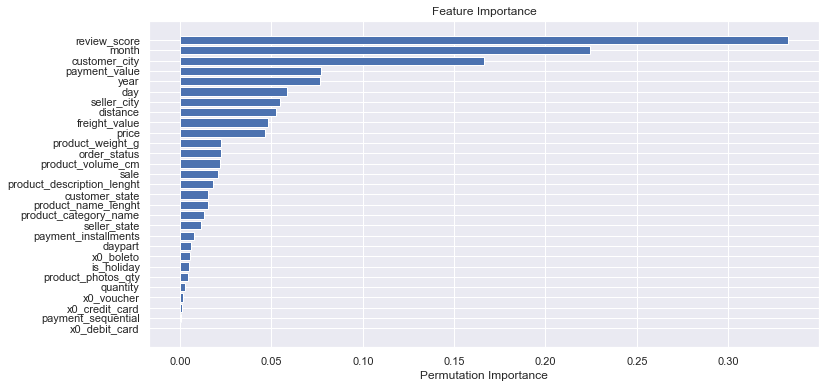

In [9]:
perm_importance = permutation_importance(pipe_LGB, X_test, y_test)

feature_names = X.columns
feat_imp = perm_importance.importances_mean
sorted_idx = feat_imp.argsort()
plt.barh(feature_names[sorted_idx], feat_imp[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance")

In [10]:
filename = '../model/LightGBM_stratified.sav'
pickle.dump(pipe_LGB, open(filename, 'wb'))

## Downsampling

In [11]:
rus = RandomUnderSampler(replacement=False, random_state=random_state)
X_dev_us, y_dev_us = rus.fit_resample(X_dev, y_dev)

### GridSearch

In [12]:
parameter_grid = {'num_leaves': [31, 63, 127],
                  'max_depth': [-1, 10, 20, 40],
                  'n_estimators': [100,200,300]}
pipe_LGB = make_pipeline(GridSearchCV(lgb.LGBMClassifier(random_state=random_state),
                                      param_grid=parameter_grid,
                                      return_train_score=True,
                                      cv=StratifiedKFold(n_splits=10,shuffle=False),
                                      n_jobs=-1, 
                                      scoring=['recall','f1'],
                                      refit='f1'))
start3 = time()
pipe_LGB.fit(X_dev_us, np.ravel(y_dev_us))
end3 = time()
print("LightGBM model takes " + str(end3-start3) + "seconds")
print("The performance of the LightGBM model on test data is ", pipe_LGB.score(X_test, y_test))
grid_search_LGB = pipe_LGB.named_steps["gridsearchcv"]
print(f"The LightGBM model Best hyperparameters is ", grid_search_LGB.best_params_)

LightGBM model takes 713.7211489677429seconds
The performance of the LightGBM model on test data is  0.424630982555539
The LightGBM model Best hyperparameters is  {'max_depth': 20, 'n_estimators': 200, 'num_leaves': 127}


### Evaluate on the Test Set

In [13]:
LGB_prediction = pipe_LGB.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test,LGB_prediction)}')
print(f'Recall: {recall_score(y_test,LGB_prediction)}')
print(f'Precision: {precision_score(y_test,LGB_prediction)}')
print(f'F-1 Score: {f1_score(y_test,LGB_prediction)}')

recall, precision = recall_score(y_test,LGB_prediction), precision_score(y_test,LGB_prediction)

Accuracy: 0.833138755567086
Recall: 0.816982214572576
Precision: 0.2868654311039484
F-1 Score: 0.424630982555539


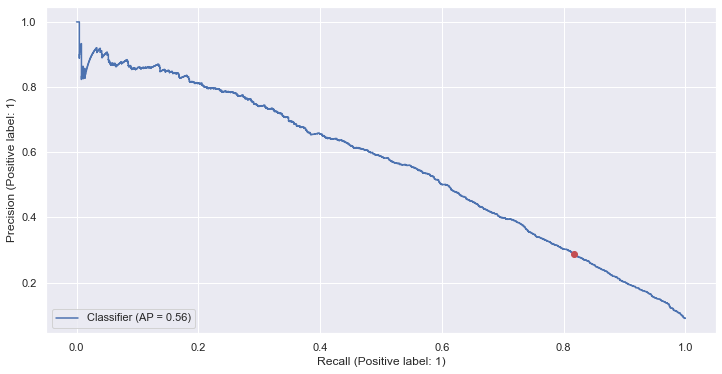

In [14]:
probs = pipe_LGB.predict_proba(X_test)[:,1]
PrecisionRecallDisplay.from_predictions(y_test, probs)
plt.plot(recall,precision,'ro');

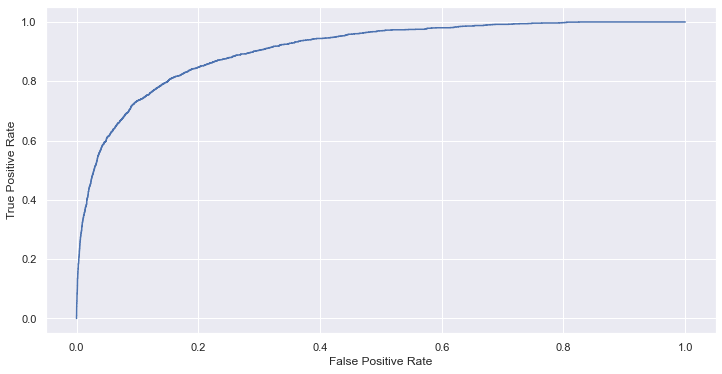

In [15]:
fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label = 1)
disp = RocCurveDisplay(fpr = fpr, tpr = tpr)
disp.plot()

Text(0.5, 1.0, 'Feature Importance')

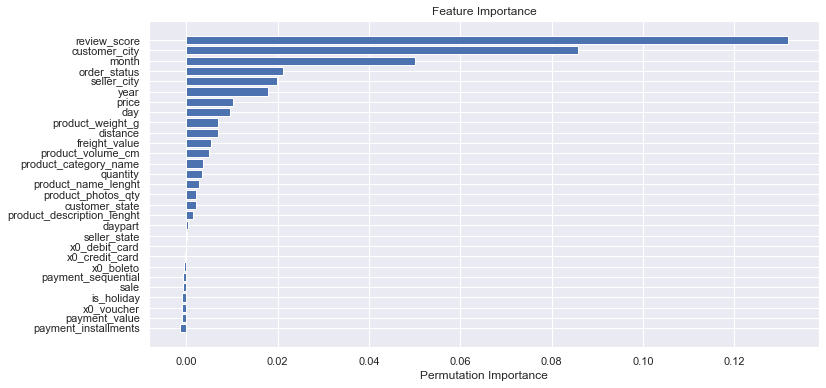

In [16]:
perm_importance = permutation_importance(pipe_LGB, X_test, y_test)

feature_names = X.columns
feat_imp = perm_importance.importances_mean
sorted_idx = feat_imp.argsort()
plt.barh(feature_names[sorted_idx], feat_imp[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance")

In [17]:
filename = '../Model/LightGBM_downsampling.sav'
pickle.dump(pipe_LGB, open(filename, 'wb'))